In [11]:
import pyspark
from pyspark import SparkContext
import json
import numpy as np
from xgboost import XGBRegressor
import sys
import time
import pickle
from tqdm import tqdm
from better_features import FeatureProcessor, read_json_data, transform_user_data, transform_business_data
from better_features import extract_review_data
from better_features import extract_business_data
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, make_scorer
from math import sqrt
from sklearn.model_selection import train_test_split

import pyspark
from pyspark import SparkContext
sc = pyspark.SparkContext()

----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 36280)
Traceback (most recent call last):
  File "/usr/lib/python3.8/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.8/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.8/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.8/socketserver.py", line 747, in __init__
    self.handle()
  File "/usr/local/lib/python3.8/dist-packages/pyspark/accumulators.py", line 262, in handle
    poll(accum_updates)
  File "/usr/local/lib/python3.8/dist-packages/pyspark/accumulators.py", line 235, in poll
    if func():
  File "/usr/local/lib/python3.8/dist-packages/pyspark/accumulators.py", line 239, in accum_updates
    num_updates = read_int(self.rfile)
  File "/usr/lo

In [12]:
# sc.stop()

In [13]:
eval_path = '../yelp_true.csv'
df_merged = pd.read_csv('xgb_log_optimize.csv')
# df_eval = pd.read_csv(eval_path)

In [14]:
# # Prediction RMSE
# df_merged = pd.merge(df_merged, df_eval, on=["user_id", "business_id"])
# eval_rmse = sqrt(mean_squared_error(df_merged['stars'], df_merged['prediction']))
# print("xgb Test RMSE:", eval_rmse)

In [15]:
# 绘图函数,实际评分（1到5星）被预测为其他评分
def plot_distribution(df, actual_star, title):
    df_star = df[df['stars'] == actual_star]

    # 对预测结果进行分档，使用自定义的分割点
    bins = [0, 1.5, 2.5, 3.5, 4.5, 5.5]
    labels = ['1-Star', '2-Star', '3-Star', '4-Star', '5-Star']
    df_star['predicted_category'] = pd.cut(df_star['prediction'], bins=bins, labels=labels, right=False)

    # 计算每个预测类别的数量
    distribution = df_star['predicted_category'].value_counts().reindex(labels, fill_value=0)
    print(f"{actual_star}-star prediction, \nerror distribution: {distribution}")

    # 绘制柱状图
    plt.figure(figsize=(5, 3))
    distribution.plot(kind='bar', color='skyblue')
    plt.title(title)
    plt.xlabel('Predicted Star Rating')
    plt.ylabel('Number of Predictions')
    plt.xticks(rotation=0)
    plt.show()

In [1]:
df_merged['error'] = df_merged['prediction'] - df_merged['stars']
error_distribution = df_merged.groupby('stars')['error'].describe()

In [ ]:
# 根据实际星级分组的误差
print(error_distribution)

In [ ]:
## 有小于1的评分，可以修正

In [ ]:
# 为实际1-5星评价绘制分布图
for star in range(1, 6):
    plot_title = f'Distribution of Predictions for Actual {star}-Star Ratings'
    plot_distribution(df_merged, star, plot_title)

### 对整体四舍五入前后误差分布对比
#### 1.0星评价
平均误差：几乎相同（2.131108 vs 2.131701），表明四舍五入对平均误差的影响非常小。
标准偏差：略有增加（0.754553 vs 0.700590），显示四舍五入后误差的分散程度略有上升。
误差范围：从0到4，与之前的范围(-0.38到4.15)相比，变得更加“整齐”且无负值。
#### 2.0星评价
平均误差：几乎相同（1.364346 vs 1.365074）。
标准偏差：同样略增（0.609505 vs 0.532484），分散程度略高。
误差范围：从-1到3，变化不大但整体更集中。
#### 3.0星评价
平均误差：几乎相同（0.543815 vs 0.546423）。
标准偏差：四舍五入后略增（0.553120 vs 0.468455）。
误差范围：从-2到2，简化了分布。
#### 4.0星评价
平均误差：几乎相同（-0.222692 vs -0.220427）。
标准偏差：略增（0.503745 vs 0.442325）。
误差范围：从-3到1，范围简化且集中。
#### 5.0星评价
平均误差：略增（-0.937955 vs -0.921321）。
标准偏差：略增（0.538664 vs 0.465962）。
误差范围：从-4到0，误差范围更集中且简化。

**说明不是数据不接近的问题，而是的的确确预测错了**

In [ ]:
df = df_merged

In [ ]:
def custom_round_up(x):
    import math
    return math.ceil(x) if x - int(x) == 0.5 else round(x)

In [ ]:
df['rounded_prediction'] = df['prediction'].apply(custom_round)

In [ ]:
# df['rounded_prediction'] = df['prediction'].round().astype(int)

In [ ]:
df['rounded_error'] = df['rounded_prediction'] - df['stars']
rounded_error_distribution = df.groupby('stars')['rounded_error'].describe()
rounded_error_distribution

In [ ]:
original_group_counts = df['prediction'].apply(lambda x: int(x)).value_counts()
rounded_group_counts = df['rounded_prediction'].apply(lambda x: int(x)).value_counts()

In [ ]:
original_group_counts

In [ ]:
rounded_group_counts

In [ ]:
test_rmse = sqrt(mean_squared_error(df['stars'], df['rounded_prediction']))
print("xgb Test ROUNDED RMSE:", test_rmse)

In [ ]:
df = df_merged

In [ ]:
## SLIGHT FIX???
# 0.9784431064627526 ORIGINAL RMSE
# 0.9784331180092208
# 0.9784324561949815
# 0.9784322072848275 >= 4.99
# 0.9784321523039587 > 5

df['adjusted_prediction'] = df['prediction'].apply(lambda x: 5 if x > 5 else x)

test_rmse = sqrt(mean_squared_error(df['stars'], df['adjusted_prediction']))
print("xgb Test ROUNDED to five star RMSE:", test_rmse)

In [ ]:
adjusted_errors_5_to_other['adjusted_prediction'].value_counts()

In [ ]:
# 筛选出实际评分为4星的数据行
adjusted_errors_5_to_other = df[(df['stars'] == 4) & (df['adjusted_prediction'] == 5)]
plot_distribution(adjusted_errors_5_to_other, 4, "")

In [ ]:
# 筛选出实际评分为5星的数据行，但预测错了的(减小了131行)
adjusted_errors_5_to_other = df[(df['stars'] == 5) & (df['adjusted_prediction'] != 5)]
plot_distribution(adjusted_errors_5_to_other, 5, "")

In [ ]:
# # 筛选出实际评分为1星的数据行
# df = df_merged
# adjusted_errors_1_to_other = df[(df['stars'] == 1)]
# plot_distribution(adjusted_errors_1_to_other, 1, "")

In [ ]:
# 筛选出真实评分为1或2星，预测评分为3星以上的数据
df = df_merged
misclassified = df[(df['stars'].isin([1, 2])) & (df['prediction'].round() >= 3)] # 至少>=2.50

In [ ]:
len(misclassified)

In [ ]:
with open('test_xgb_without_embedding', "rb") as model_file:
    xgb_model = pickle.load(model_file)

In [ ]:
# 假设xgb_model是已经训练好的XGBoost模型
booster = xgb_model.get_booster()
feature_importance = booster.get_score(importance_type='weight')

# 将特征重要性转换为排序的列表
sorted_feature_importance = sorted(feature_importance.items(), key=lambda item: item[1], reverse=True)

# 打印出最重要的特征和它们的分数
for feature, importance in sorted_feature_importance:
    print(f"Feature: {feature}, Importance: {importance}")

In [ ]:
from better_features import FeatureProcessor, read_json_data, transform_user_data, transform_business_data
from better_features import extract_review_data
from better_features import extract_business_data

# def process_training_data(train_path):
#     try:
#         lines_train = sc.textFile(train_path)
#         train_data = lines_train.filter(lambda row: not row.startswith('user_id')).map(lambda line: line.split(',')).collect()
#         train_df = pd.DataFrame(train_data, columns=['user_id', 'business_id', 'stars'])
#         train_df['stars'] = train_df['stars'].astype(float)

#         processed_df = feature_processor.process_all_features(train_df)

#         X = processed_df.drop(['stars', 'user_id', 'business_id'], axis=1)
#         y = processed_df['stars']

#         return X, y
#     except Exception as e:
#         print(f"An error occurred: {e}")
#         return None, None
        
# sc = pyspark.SparkContext()

# folder_path = '../data/'
# user_df = pd.read_csv('../well-trained/cache/user_df.csv')
# business_df = pd.read_csv('../well-trained/cache/business_df.csv')
# review_data = read_json_data(folder_path + '/review_train.json', extract_review_data, sc).collect()

# feature_processor = FeatureProcessor(user_df, business_df, review_data)
# X_val, y_val = process_training_data('../yelp_true.csv')
# combined_val_processed = pd.concat([X_val, df_merged['stars'], df_merged['prediction']], axis=1)
# combined_val_processed.to_csv('combined_train_processed.csv', index=False)

# predictionss = xgb_model.predict(X_val)
# combined_val_processed = pd.concat([X_val, pd.Series(y_val), pd.Series(predictionss, name='prediction')], axis=1)

In [ ]:
combined_val_processed = pd.read_csv('combined_val_processed.csv')

In [ ]:
important_features = [feature for feature, importance in sorted_feature_importance[:20]]  # 取前10个最重要的特征
all_misclassified_high = combined_val_processed[important_features]
all_misclassified_high = (pd.concat([all_misclassified_high, df_merged['user_id'], df_merged['business_id']], axis=1))

eval_misclassification = pd.merge(all_misclassified_high, misclassified, on=['user_id', 'business_id'])
eval_misclassification['rounded_prediction'] = eval_misclassification['prediction'].round()

In [ ]:
eval_misclassification

In [ ]:
misclassified_high_descriptive = eval_misclassification.describe()
# misclassified_high_descriptive

In [ ]:
# combined_val_processed[combined_val_processed['prediction'] > 5]

In [ ]:
import seaborn as sns

# 对于每个重要特征，使用箱型图或小提琴图比较其分布
for feature in important_features:
    plt.figure(figsize=(15, 10))
    sns.boxplot(data=eval_misclassification, x='rounded_prediction', y=feature)
    plt.title(f"Distribution of {feature} for Misclassified Low Ratings")
    plt.show()

- bus_review_count在不同的真实评分中变化不大
  
- **average_stars,**
这个箱型图展示了用户的平均评分（average_stars）在不同预测评级（rounded_prediction）下的分布情况。这里，我们关注的是将低评价（实际为1或2星）错误分类为3、4、5星的情况。
分析如下：
3星预测：
数据中心趋于接近3.5星，这意味着对于被预测为3星的用户，他们的平均评分实际上高于3星。可能有数据集的偏差，或者这些用户可能普遍对商家更宽容。
数据的分布范围（四分位数范围）相对较宽，尤其是下四分位数范围，延伸至2星以下，这可能意味着有一些用户尽管给出很低的评价，但他们的整体平均评分较高。
存在一些异常值，即那些低评分被显著高估的实例。
4星预测：
数据中心同样偏高，中位数接近4星，这暗示模型对那些平均评分高的用户的评价偏高。
分布的四分位数范围稍微集中，比3星的分布窄，表明被预测为4星的用户在平均评分上更加一致。
仍然存在异常值，这表明有少数用户的评价被极度高估。
5星预测：
分布中心也偏高，中位数在4星以上。这说明当模型将评价预测为5星时，这些用户通常的平均评分也很高。
分布四分位数范围相对于3星和4星的预测更为集中，这可能是因为在该数据集中，用户的平均评分真的很高。
异常值减少了，但仍然存在。这些数据点可能代表了模型在预测时的极端情况。
可能的原因分析：
数据不平衡：
如果数据集中高评分用户比例较高，那么模型可能会学习到偏向于预测更高的评分。
特征关联：
用户的平均评分average_stars可能与其他特征存在一定的关联，导致模型倾向于根据用户的一般慷慨度给出高预测。
为了提高模型的准确度，你可以考虑进行进一步的特征工程，尝试不同的模型超参数，或者探索更复杂的模型结构。此外，也可以进行更深入的数据质量评估，确保训练数据没有错误或偏差

- average_useful_stars
箱型图分析：
3星预测：
大部分数据聚集在相对低的avg_useful_score范围内，中位数接近于0，这意味着即使商家的评论在大多数情况下被认为不是很有用，这些评论也可能被模型预测为3星。
数据分布的范围较窄，表明对于这类预测错误的实例，avg_useful_score的变异度不大。
有一些离群点分布在高avg_useful_score值处，这可能表明少数的商家获得了一些特别高的有用评价。
4星预测：
这一类的中位数稍微高于3星预测，但仍然比较低。
分布范围相比3星预测略宽，表明在被错误预测为4星的实例中，avg_useful_score有更广的变化。
离群点数量增多，显示在4星预测中存在更多的实例，它们的avg_useful_score值异常高。
5星预测：
中位数进一步上升，但依然不高，表明即使是被预测为5星的商家，它们的评论也不一定普遍认为是有用的。
分布范围与4星预测相似，但离群点较少，这可能表明被预测为5星的错误分类实例中，高avg_useful_score值的情况相对较少。
可能的原因分析：
特征相关性：
avg_useful_score可能与其他一些未显示在图中的特征有关联，例如商家的总体评分或者评论的数量，而这些关联可能在模型训练中没有得到充分考虑。
用户行为：
用户可能倾向于对他们觉得好的商家更多地点击“有用”，这可能会导致预测评分偏高。
模型解释性：
需要进一步的模型解释工作，以确定模型是如何使用avg_useful_score这个特征的，并了解其在预测中的确切作用。
要改进模型预测，可以考虑以下几个方面：
数据处理：对离群点进行进一步分析，确定它们是否代表正常的用户行为或数据质量问题。
特征工程：可能需要对avg_useful_score进行归一化或变换，以减少异常值的影响。
模型调整：考虑使用正则化方法来减少对离群点的敏感度，或者尝试不同的模型结构来更好地捕获数据中的复杂关系。

- **bus_stars,**
对于被误分类的低评分（真实评分为1星或2星的数据），商家平均星级的中位数在3.5星左右，这表明即便是低分的评价，这些商家的整体平均星级也比较高。 如果一个商家的整体评级很高，模型可能就会忽略掉个别低分评价，依然给出较高的预测评分。
3星预测：
中位数约为3.0，说明对于被预测为3星的评论，这些商家的平均评分大体上符合预测。
分布的四分位距离较窄，表示大部分商家的平均星级较为集中在3星左右。
出现了几个低异常值，暗示一些实际评分较低的商家被预测为3星。
4星预测：
中位数略高于4星，说明在这些被误分类为4星的案例中，商家的平均星级通常也比较高。
四分位范围宽度适中，表明这类误分类的商家星级分布有一定的波动。
=存在一些低异常值。
5星预测：
中位数接近4.5星，表明那些被错误地预测为5星的商家，他们的平均星级通常很高。
分布的四分位距离相对于3星和4星预测略宽，这表明5星预测中商家星级的差异可能更大。
有少量的低异常值出现。
可能的原因分析：
预测偏差：
如果模型在某些情况下高估了低评价的商家，那么可能是由于模型过于重视bus_stars这个特征，尤其是当商家的总体评价较好时。
数据质量：
异常值的出现可能是由于一些数据质量问题，如评分不准确或个别用户评价行为的偏差。
商家评分的影响：
bus_stars特征的分布暗示，模型可能倾向于相信，平均而言，商家的整体评分是可靠的指标，即便面对一些低评价。
为了提升模型预测的准确性，可以采取以下措施：
调整特征权重：对模型中bus_stars的权重进行调整，避免模型过度依赖商家的平均星级。
考虑上下文信息：加入更多与用户-商家交互相关的特征，以提供对评分影响更全面的视角。
深入数据探索：深入分析异常值背后的数据，以理解这些商家为何能获得较高的平均评分，但在某些情况下得到了低评价。
通过这些措施，可以更准确地捕捉到那些导致误分类的复杂关系，并相应地调整模型。

- **city_encoded**
3星预测：
中位数较低，表示在被预测为3星的误分类中，大多数商家位于较低编号的城市。
四分位距离较大，说明这些误分类的商家分布在很宽的城市编码范围内。
有较多的低异常值，这可能指出一些特定的较低编号城市中商家的低评价被过高预测。
4星预测：
中位数更高，表明被误分类为4星的商家普遍位于编号更高的城市。
分布的四分位距离较窄，特别是下四分位数，意味着在较高编号的城市中，商家的评价倾向于被高估为4星。
出现了一些较高的异常值，指出在某些高编号城市，商家的评价有被显著高估的情况。
5星预测：
中位数和四分位距离均较4星预测时更低，表明误分类为5星的商家在编号更低的城市中较为常见。
分布中存在几个高异常值，这表明个别城市中的商家评价可能被高估。
可能的原因分析：
城市效应：
城市编码可能与其他一些不可观测的地理或经济特征相关，如城市规模、市场饱和度或消费者偏好。
模型学习的偏差：
如果city_encoded较高或较低的城市与其他积极或消极的特征一致性较高，则模型可能在不知不觉中学习到了这一关联，导致对这些地区商家的评价预测存在偏差。
数据不均衡：
某些编号的城市可能在数据集中代表性不足或过剩，导致模型在这些地区的预测表现不佳。
要提升模型预测的准确性，可以采取以下措施：
地理特征工程：深入研究city_encoded与目标变量之间的关系，可能需要更详细的地理信息来帮助模型更好地理解背景。
更复杂的模型：考虑使用可以捕获更复杂关系的模型，如随机森林或神经网络。
消除偏差：如果发现city_encoded导致不合理的预测偏差，可以尝试从特征集中移除它，或使用不同的编码策略。

- yelp_since & elite_years
elite_years 箱型图分析
中位数在3星和4星预测类别中相对较低，尤其在3星预测中更为显著，这可能表明精英用户更少被错误预测为低分。
5星预测中的四分位数范围最小，中位数也更低，这表明被错误预测为5星的用户中，精英年数通常不高。
类似地，存在一些高异常值，可能指出了个别精英用户的评分被高估。
结论和可能的原因
在yelping_since中的中等和稳定的中位数表明，用户在Yelp上的活跃时间对评分预测的影响可能不是很明显，或者模型没有充分利用这个特征来区分评分。
对于elite_years，较低的中位数和四分位数范围可能说明精英用户更少被高估评分，但这种趋势在预测5星时不明显

In [ ]:
eval_misclassification[(eval_misclassification['average_stars'] >= 3) & (eval_misclassification['prediction'] >= 2)]

In [ ]:
eval_misclassification[(eval_misclassification['bus_stars'] >= 4) & (eval_misclassification['prediction'] >= 2)]

In [ ]:
eval_misclassification[(eval_misclassification['avg_useful_score'] >= 4) & (eval_misclassification['prediction'] >= 3)]

In [ ]:
eval_misclassification['city_encoded'].value_counts()

In [ ]:
errors = misclassified_city['prediction'] - misclassified_city['stars']
print("Root Mean Squared Error (RMSE) of MisClassified Cities:", np.sqrt(mean_squared_error(misclassified_city['stars'], misclassified_city['prediction'])))

In [ ]:
misclassified

In [ ]:
feature_processor.business_df[feature_processor.business_df['city_encoded'].isin([416, 769, 155, 333, 725])]

In [ ]:
city_encoded_counts = feature_processor.business_df['city_encoded'].value_counts()
total_rows = len(feature_processor.business_df)
city_encoded_percentages = (city_encoded_counts / total_rows) * 100
print(city_encoded_percentages)
city_encoded_percentages[416], city_encoded_percentages[769], city_encoded_percentages[155], city_encoded_percentages[333], city_encoded_percentages[725]

In [ ]:
eval_city_misclassified = eval_misclassification[(eval_misclassification['city_encoded'].isin([416, 769, 155, 333, 725]))]
# eval_city_misclassified

In [ ]:
# eval_city_misclassified.to_csv('city_misclassified.csv', index=False)
# eval_misclassification.to_csv('eval_features_misclassified.csv', index=False)
eval_misclassification[(eval_misclassification['average_stars'] >= 3) & (eval_misclassification['prediction'] >= 2)]
eval_misclassification[(eval_misclassification['bus_stars'] >= 4) & (eval_misclassification['prediction'] >= 2)]
eval_misclassification[(eval_misclassification['avg_useful_score'] >= 4) & (eval_misclassification['prediction'] >= 3)]

In [ ]:
import xgboost as xgb
xgb.plot_importance(xgb_model)
plt.show()

In [ ]:
eval_misclassification.head()

In [ ]:
sns.set(style="whitegrid")
# 创建一个图形框
fig, axes = plt.subplots(2, 1, figsize=(5, 7))
# 在第一个轴上绘制预测评分的密度图
sns.histplot(eval_city_misclassified['prediction'], kde=True, ax=axes[0], bins=30, color='blue')
axes[0].set_title('Distribution of Predictions')

sns.histplot(eval_city_misclassified['stars'], kde=True, ax=axes[1], bins=30, color='green')
axes[1].set_title('Distribution of Actual Stars')
plt.tight_layout()
plt.show()

In [ ]:
# specific_city_data = combined_val_processed[(combined_val_processed['city_encoded'].isin([416, 769, 155, 333, 725]))]
specific_city_data = combined_val_processed[(combined_val_processed['city_encoded'].isin([416, 769, 155, 333, 725]))]
specific_city_data_stars_2_or_less = specific_city_data[specific_city_data['stars'] <= 2]

sns.set(style="whitegrid")
# 创建一个图形框
fig, axes = plt.subplots(2, 1, figsize=(5, 7))
# 在第一个轴上绘制预测评分的密度图
sns.histplot(specific_city_data_stars_2_or_less['prediction'], kde=True, ax=axes[0], bins=30, color='blue')
axes[0].set_title('Distribution of Predictions')

sns.histplot(specific_city_data_stars_2_or_less['stars'], kde=True, ax=axes[1], bins=30, color='green')
axes[1].set_title('Distribution of Actual Stars')
plt.tight_layout()
plt.show()

In [ ]:
all_city_data_stars_2_or_less = combined_val_processed[combined_val_processed['stars'] <= 2]
all_city_data_stars_2_or_less = all_city_data_stars_2_or_less[~all_city_data_stars_2_or_less['city_encoded'].isin([416, 769, 155, 333, 725])]

sns.set(style="whitegrid")
# 创建一个图形框
fig, axes = plt.subplots(2, 1, figsize=(5, 7))
# 在第一个轴上绘制预测评分的密度图
sns.histplot(all_city_data_stars_2_or_less['prediction'], kde=True, ax=axes[0], bins=30, color='blue')
axes[0].set_title('Distribution of Predictions')

sns.histplot(all_city_data_stars_2_or_less['stars'], kde=True, ax=axes[1], bins=30, color='green')
axes[1].set_title('Distribution of Actual Stars')
plt.tight_layout()
plt.show()

In [ ]:
sns.jointplot(x='prediction', y='stars', data=specific_city_data, kind='hex', color='red')
plt.suptitle('Joint Distribution of Prediction and Actual Stars')
plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(data=eval_city_misclassified, x='city_encoded', y='prediction', color='lightblue', ax=ax)
sns.boxplot(data=eval_city_misclassified, x='city_encoded', y='stars', color='lightgreen', ax=ax)
plt.title('Box Plot of Predictions and Actual Stars by City')
plt.xlabel('City Encoded')
plt.ylabel('Ratings')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
# sns.boxplot(data=specific_city_data, x='city_encoded', y='prediction', color='lightblue', ax=ax)
sns.boxplot(data=specific_city_data, x='city_encoded', y='stars', color='lightgreen', ax=ax)
plt.title('Box Plot of Predictions and Actual Stars by City')
plt.xlabel('City Encoded')
plt.ylabel('Ratings')
plt.show()

In [ ]:
# fig, ax = plt.subplots(figsize=(80, 10))
# # sns.boxplot(data=specific_city_data, x='city_encoded', y='prediction', color='lightblue', ax=ax)
# sns.boxplot(data=combined_val_processed, x='city_encoded', y='stars', color='lightgreen', ax=ax)
# plt.title('Box Plot of Predictions and Actual Stars by City')
# plt.xlabel('City Encoded')
# plt.ylabel('Ratings')
# plt.show()

In [ ]:
specific_city_data = combined_val_processed[(combined_val_processed['city_encoded'].isin([416, 769, 155, 333, 725]))]
specific_city_data_stars_2_or_less = specific_city_data[specific_city_data['stars'] <= 2]

sns.set(style="whitegrid")
# 创建一个图形框
fig, axes = plt.subplots(2, 1, figsize=(15, 5))
# 在第一个轴上绘制预测评分的密度图
sns.histplot(specific_city_data_stars_2_or_less['useful'], kde=True, ax=axes[0], bins=20, color='blue')
axes[0].set_title('Distribution of bus_review_count')

sns.histplot(specific_city_data_stars_2_or_less['prediction'], kde=True, ax=axes[1], bins=5, color='green')
axes[1].set_title('Distribution of Actual Stars')
plt.tight_layout()
plt.show()

In [ ]:
all_city_data_stars_2_or_less = combined_val_processed[combined_val_processed['stars'] <= 2]
all_city_data_stars_2_or_less = all_city_data_stars_2_or_less[~all_city_data_stars_2_or_less['city_encoded'].isin([416, 769, 155, 333, 725])]

sns.set(style="whitegrid")
# 创建一个图形框
fig, axes = plt.subplots(2, 1, figsize=(15, 5))
# 在第一个轴上绘制预测评分的密度图
sns.histplot(all_city_data_stars_2_or_less['useful'], kde=True, ax=axes[0], bins=20, color='blue')
axes[0].set_title('Distribution of bus_review_count')

sns.histplot(all_city_data_stars_2_or_less['prediction'], kde=True, ax=axes[1], bins=5, color='green')
axes[1].set_title('Distribution of Actual Stars')
plt.tight_layout()
plt.show()

### Process Data and Load Model

In [17]:
# use the best XGB model found so far
with open('test_xgb_grid_search_huge_09780', "rb") as model_file:
    all_data_xgb_model = pickle.load(model_file)

all_data_xgb_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.2, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.04, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=90,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=550, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [18]:
xgb_model = XGBRegressor(max_depth=7, learning_rate=0.04, n_estimators=550, max_leaves=90, gamma=0.2, colsample_bytree=0.8, subsample=0.9)

In [19]:
def process_training_data(train_path):
    try:
        lines_train = sc.textFile(train_path)
        train_data = lines_train.filter(lambda row: not row.startswith('user_id')).map(lambda line: line.split(',')).collect()
        train_df = pd.DataFrame(train_data, columns=['user_id', 'business_id', 'stars'])
        train_df['stars'] = train_df['stars'].astype(float)

        processed_df = feature_processor.process_all_features(train_df)

        X = processed_df.drop(['stars', 'user_id', 'business_id'], axis=1)
        y = processed_df['stars']

        return X, y
    except Exception as e:
        print(f"An error occurred: {e}")
        return None, None

In [20]:
folder_path = '../data/'
user_df = pd.read_csv('../well-trained/cache/user_df.csv')
business_df = pd.read_csv('../well-trained/cache/business_df.csv')
review_data = read_json_data(folder_path + '/review_train.json', extract_review_data, sc).collect()

feature_processor = FeatureProcessor(user_df, business_df, review_data)

In [21]:
city_misclassified = pd.read_csv('city_misclassified.csv')

city_misclassified_selected = city_misclassified[['user_id', 'business_id', 'stars']]
processed_df = feature_processor.process_all_features(city_misclassified_selected)
X_val = processed_df.drop(['stars', 'user_id', 'business_id'], axis=1)
y_val = processed_df['stars']

### FINE TUNE SEARCH ON THE yelp true  DATA

In [55]:
X_eval, y_eval = process_training_data(eval_path)

In [56]:
# Filter out some features in X_eval
X_eval = X_eval.drop(['compliments', 'num_interactions', 'compliment_cool'], axis=1)
X_eval.columns

Index(['average_stars', 'user_review_count', 'fans', 'useful', 'funny', 'cool',
       'yelping_since', 'friends_count', 'elite_years', 'compliment_hot',
       'compliment_more', 'compliment_profile', 'compliment_cute',
       'compliment_list', 'compliment_note', 'compliment_plain',
       'compliment_writer', 'compliment_photos', 'bus_stars',
       'bus_review_count', 'is_open', 'city_encoded', 'avg_useful_score'],
      dtype='object')

In [57]:
# train test split
X_eval_train, X_eval_test, y_eval_train, y_eval_test = train_test_split(X_eval, y_eval, test_size=0.3, random_state=42)

In [59]:
!pip install hyperopt

     |████████████████████████████████| 1.6 MB 4.3 MB/s eta 0:00:01
     |████████████████████████████████| 491 kB 13.7 MB/s eta 0:00:01


In [67]:
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from scipy.stats import pearsonr


# 定义搜索空间
space = {
    'max_depth': hp.choice('max_depth', range(0, 6)),  # 扩大最大深度的选择范围
    # 'subsample': hp.uniform('subsample', 0.1, 0.7),  # 扩大subsample的搜索范围 # negative impact
    'colsample_bytree': hp.uniform('colsample_bytree', 0.4, 1.0),  # 扩大colsample的搜索范围
    'n_estimators': hp.choice('n_estimators', [0, 100, 200, 300, 400, 500]),  # 增加树的数量的选项
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.05),  # 维持当前的学习率范围
    # 'gamma': hp.uniform('gamma', 0, 1),  # 扩大gamma的搜索范围 # negative impact
    'min_child_weight': hp.choice('min_child_weight', range(2, 10))  # 扩大最小子权重的选择范围
}

# 目标函数
def objective(params):
    model = XGBRegressor(**params, objective='reg:squarederror')
    score = cross_val_score(model, X_eval_train, y_eval_train, scoring=rmse_scorer, cv=3).mean()
    return {'loss': -score, 'status': STATUS_OK}

# 运行贝叶斯优化
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=300, trials=trials)


####################
# 存储参数和对应的RMSE
data = []
for trial in trials.trials:
    params = trial['misc']['vals']
    # 把参数值从列表转换成单一的值
    params = {key: val[0] for key, val in params.items()}
    loss = trial['result']['loss']
    params['rmse'] = -loss  # 转换回正值，因为最小化RMSE
    data.append(params)

# 创建DataFrame
df = pd.DataFrame(data)

# 计算每个参数与RMSE的相关系数
correlations = {}
for param in df.columns[:-1]:  # 最后一列是RMSE，不需要自相关
    corr, _ = pearsonr(df[param], df['rmse'])
    correlations[param] = corr

print("参数与RMSE的相关性:", correlations)
#######################
print("最佳参数:", best)

100%|███████| 300/300 [57:08<00:00, 11.43s/trial, best loss: 0.9817427760108877]
参数与RMSE的相关性: {'colsample_bytree': 0.08028575821226164, 'learning_rate': 0.09792830087989665, 'max_depth': 0.03759792500401914, 'min_child_weight': -0.055416491608809036, 'n_estimators': 0.6613364387347169}
最佳参数: {'colsample_bytree': 0.47563883703337595, 'learning_rate': 0.034051997969913164, 'max_depth': 4, 'min_child_weight': 6, 'n_estimators': 5}


In [58]:
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, make_scorer
from xgboost import XGBRegressor

# 初始参数和参数网格
params = {
    'max_depth': 5,
    'colsample_bytree': 0.7,
    'subsample': 0.9,
    'objective': 'reg:squarederror', # minimize MSE
}

param_grid = {
    'max_depth': [3, 4, 5, 6, 7],
    'subsample': [0.8, 0.85, 0.9, 0.95],
    'colsample_bytree': [0.6, 0.65, 0.7, 0.75, 0.8],
    'learning_rate': [0.01, 0.02, 0.03],
    'n_estimators': [100, 300, 500, 700],
    # 'gamma': [0, 0.1, 0.2],
    'min_child_weight': [1, 2, 3]
}

# param_grid = {
#     'max_depth': [5, 6, 7],
#     'subsample': [0.8, 0.9, 1.0],
#     'colsample_bytree': [0.6, 0.7, 0.8],
#     'learning_rate': [0.01, 0.05, 0.1],  # 添加不同的学习率
#     'n_estimators': [100, 500, 1000],     # 不同的树的数量
#     'gamma': [0, 0.1, 0.2],               # 调整gamma探索不同的值
#     'min_child_weight': [1, 5, 10],       # 探索不同的最小子节点权重
#     'reg_alpha': [0, 0.1, 1],             # L1正则化
#     'reg_lambda': [1, 2, 5]               # L2正则化
# }

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def find_best_model(X_train, y_train, initial_params, initial_param_grid, scorer, threshold):
    model = XGBRegressor(**initial_params)
    grid_search = GridSearchCV(estimator=model, param_grid=initial_param_grid, scoring=scorer, cv=2, verbose=1)
    grid_search.fit(X_train, y_train)
    best_rmse = np.abs(grid_search.best_score_)

    # if best_rmse > threshold:
    #     print(f"首轮搜索的最佳RMSE {best_rmse} 没有低于阈值 {threshold}。正在调整参数范围进行第二轮搜索...")
    #     # 根据需求调整参数范围进行第二轮搜索
    #     second_param_grid = {
    #         'max_depth': [4, 5, 6, 7, 8],       # 更广的深度范围
    #         'subsample': [0.6, 0.7, 0.8, 0.9],  # 更广的子样本范围
    #         'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9],  # 更广的列采样比例范围
    #         'learning_rate': [0.01, 0.02, 0.05],  # 添加学习率参数
    #         'n_estimators': [100, 300, 500, 700],  # 探索更多的树的数量选项
    #         'gamma': [0, 0.1, 0.2, 0.3],  # 包含更多的gamma值
    #         'min_child_weight': [1, 3, 5, 10],  # 探索不同的最小子节点权重
    #         'reg_alpha': [0, 0.1, 0.5],  # L1正则化参数
    #         'reg_lambda': [0.5, 1, 1.5, 2]  # L2正则化参数
    #     }

    #     grid_search = GridSearchCV(estimator=model, param_grid=second_param_grid, scoring=scorer, cv=3, verbose=2)
    #     grid_search.fit(X_train, y_train)
    #     best_rmse = np.abs(grid_search.best_score_)
    if best_rmse < rmse_threshold:
        return grid_search.best_params_, best_rmse

    return grid_search.best_params_, best_rmse


rmse_scorer = make_scorer(rmse, greater_is_better=False)
# 设置RMSE阈值
rmse_threshold = 0.97  # 示例阈值

# 假设X_eval_train, y_eval_train已经被定义和赋值
best_params, best_rmse = find_best_model(X_eval_train, y_eval_train, params, param_grid, rmse_scorer, rmse_threshold)
print("最佳参数:", best_params)
print("最佳RMSE:", best_rmse)

Fitting 2 folds for each of 3600 candidates, totalling 7200 fits
最佳参数: {'colsample_bytree': 0.75, 'learning_rate': 0.02, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 500, 'subsample': 0.85}
最佳RMSE: 0.9820519901373014


最佳参数: {'colsample_bytree': 0.7, 'max_depth': 5, 'subsample': 0.9}
最佳RMSE: 0.9826787085327832

最佳参数: {'colsample_bytree': 0.75, 'gamma': 0.1, 'learning_rate': 0.02, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 550, 'subsample': 0.85}
最佳RMSE: 0.98199654997737

最佳参数: {'colsample_bytree': 0.757795913908719, 'gamma': 0.3627939862810188, 'learning_rate': 0.02182484119103349, 'max_depth': 1, 'min_child_weight': 0, 'n_estimators': 2, 'subsample': 0.6968106825457294}
0.9815862043743494

最佳参数: {'colsample_bytree': 0.6463191813968516, 'gamma': 0.36184067784605295, 'learning_rate': 0.016676426078392606, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 4, 'subsample': 0.6295001902086587}
best loss: 0.9814745011567303]

### Testing if adjusting and standardizing features work
#### Filter out some features in X_eval

In [49]:
X_eval, y_eval = process_training_data(eval_path)
X_eval = X_eval.drop(['compliments', 'num_interactions', 'compliment_cool'], axis=1)
X_eval_train, X_eval_test, y_eval_train, y_eval_test = train_test_split(X_eval, y_eval, test_size=0.3, random_state=42)

In [50]:
best_params

{'colsample_bytree': 0.75,
 'gamma': 0.1,
 'learning_rate': 0.02,
 'max_depth': 4,
 'min_child_weight': 1,
 'n_estimators': 550,
 'subsample': 0.85}

In [51]:
re_model = XGBRegressor(**best_params)
re_model.fit(X_eval_train, y_eval_train)

re_model_predictions = re_model.predict(X_eval_test)
sqrt(mean_squared_error(re_model_predictions, y_eval_test))

0.9852171012940896

In [ ]:
# 目的是为了能够找到一个比较好的模型，然后通过解释模型的特征分析哪些参数更重要?

### GRID SEARCH ON THE MISCLASSIFIED CITY DATA

In [24]:
# 分割数据集，这里以70%的数据作为训练集，30%的数据作为测试集
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_val, y_val, test_size=0.3, random_state=42)

In [31]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, make_scorer
# GRID Search 找到最好的XGB模型能够降低misclassified_city的RMSE
# best params on all data
params = {
    'max_depth': 7,
    'learning_rate': 0.04,
    'n_estimators': 550,
    'max_leaves': 90,
    'gamma': 0.2,
    'colsample_bytree': 0.8,
    'subsample': 0.9
}

param_grid = {
    'max_depth': [6, 7, 8],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)
model = XGBRegressor(**params)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring=rmse_scorer, cv=3, verbose=2)
grid_search.fit(X_train, y_train)

print("最佳参数:", grid_search.best_params_)
best_rmse = np.abs(grid_search.best_score_)
print("最佳RMSE:", best_rmse)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END ...colsample_bytree=0.7, max_depth=6, subsample=0.8; total time=   0.6s
[CV] END ...colsample_bytree=0.7, max_depth=6, subsample=0.8; total time=   0.5s
[CV] END ...colsample_bytree=0.7, max_depth=6, subsample=0.8; total time=   0.5s
[CV] END ...colsample_bytree=0.7, max_depth=6, subsample=0.9; total time=   0.4s
[CV] END ...colsample_bytree=0.7, max_depth=6, subsample=0.9; total time=   0.4s
[CV] END ...colsample_bytree=0.7, max_depth=6, subsample=0.9; total time=   0.3s
[CV] END ...colsample_bytree=0.7, max_depth=6, subsample=1.0; total time=   0.2s
[CV] END ...colsample_bytree=0.7, max_depth=6, subsample=1.0; total time=   0.2s
[CV] END ...colsample_bytree=0.7, max_depth=6, subsample=1.0; total time=   0.2s
[CV] END ...colsample_bytree=0.7, max_depth=7, subsample=0.8; total time=   0.4s
[CV] END ...colsample_bytree=0.7, max_depth=7, subsample=0.8; total time=   0.5s
[CV] END ...colsample_bytree=0.7, max_depth=7, s

In [28]:
sqrt(mean_squared_error(city_misclassified['stars'], city_misclassified['prediction']))

1.949933887421878

最佳参数: {'colsample_bytree': 0.7, 'max_depth': 6, 'subsample': 1.0}
最佳RMSE: 0.4718569379128515

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

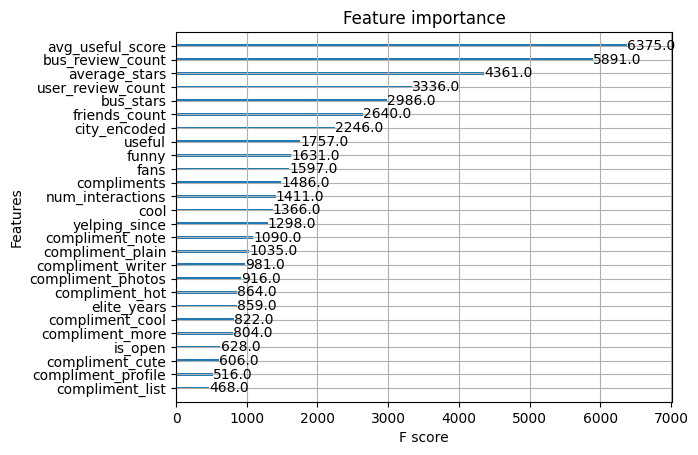

In [32]:
xgb.plot_importance(xgb_model)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

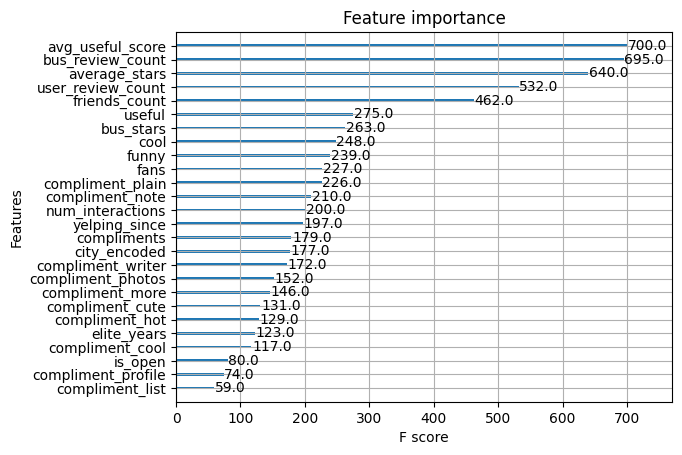

In [49]:
xgb.plot_importance(best_model)

avg_useful_score, bus_review_count, average_stars, user_review_count, bus_stars,
friend_count, city_encoded, useful, funny, fans
可以看到city_encoded在这个数据集上的重要性提升很多。

In [34]:
grid_search

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.8,
                                    device=None, early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=0.2,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=0.04, max...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=7, max_leaves=90,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=550,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'colsample_bytree': [0.7, 0.8, 0.9],
                         'max_depth': [6, 7, 8], 'subsample': [0.8, 0.9, 1.0]},
             scoring=make_scorer(rmse, greater_is_better=False), verbose=2)

### Explain the Result

#### misclassified_city

In [74]:
# !pip install shap
best_model = grid_search.best_estimator_

In [77]:
best_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.2, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.04, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=90,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=550, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

##### shap 

In [78]:
import shap
# 初始化一个解释器
explainer = shap.TreeExplainer(best_model)

# 计算SHAP值（这里的X_train可以是你用来训练模型的部分数据集）
shap_values = explainer.shap_values(X_test)

# 可视化第一个预测的解释
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])

在这张图中，每个特征对预测结果的贡献程度都被显示出来。这个预测的基准值是1.61，也就是说，如果没有任何特征的影响，模型预测的输出将是1.61。

在图中，特征的SHAP值以箭头表示，箭头的方向和颜色表示了该特征是如何影响预测结果的：

红色箭头表示一个特征使得预测值比基准值高。
蓝色箭头表示一个特征使得预测值比基准值低。
箭头的长度表示了该特征影响的大小，长度越长，影响越大。
以图中的几个特征为例：

num_interactions（交互数）: 这个特征的SHAP值为正，意味着较高的交互数使得预测值上升到最终的预测值1.91。
is_open=1（是否开放）: 这个特征同样推高了预测值。
yelping_since（加入Yelp时间）: 此特征有一个轻微的正向贡献。
useful（有用的评价数）: 这个特征显著地推高了预测值。

相反，有一些特征是对预测结果产生负面影响的，比如：
compliment_note=1（收到的赞扬笔记数）: 这个特征降低了预测值。
friends_count（朋友数）: 这个特征也略微降低了预测值。
根据这些信息，我们可以得出结论，对于这个特定的预测，一些特征如num_interactions和useful对预测值有较大的正向贡献，而其他特征则可能对结果产生了负面影响。

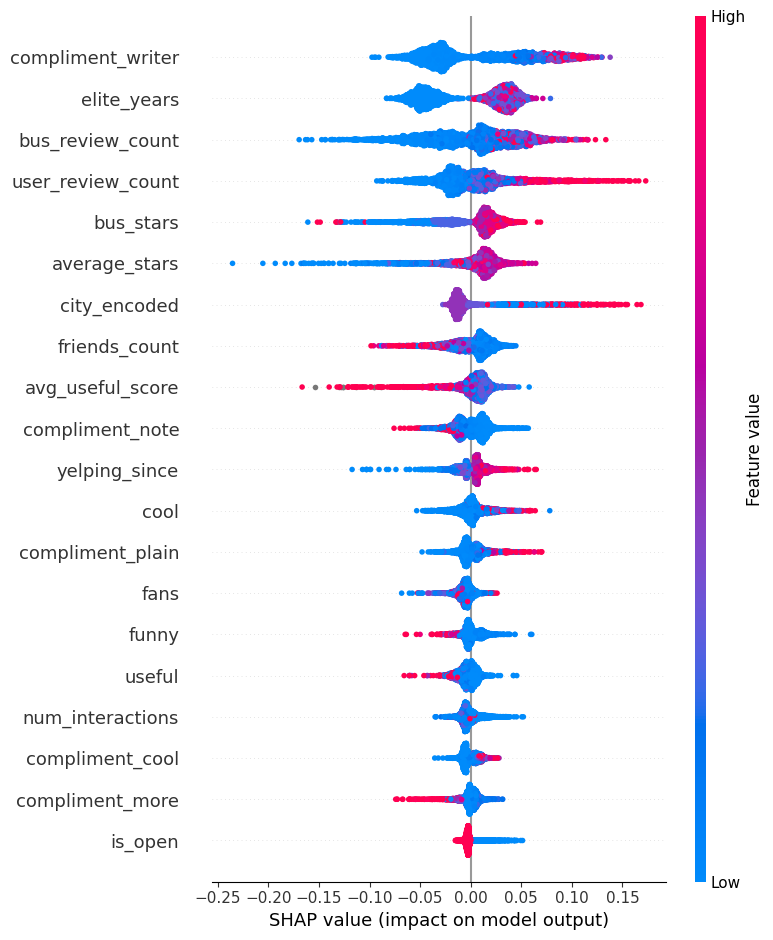

In [79]:
shap.summary_plot(shap_values, X_test)

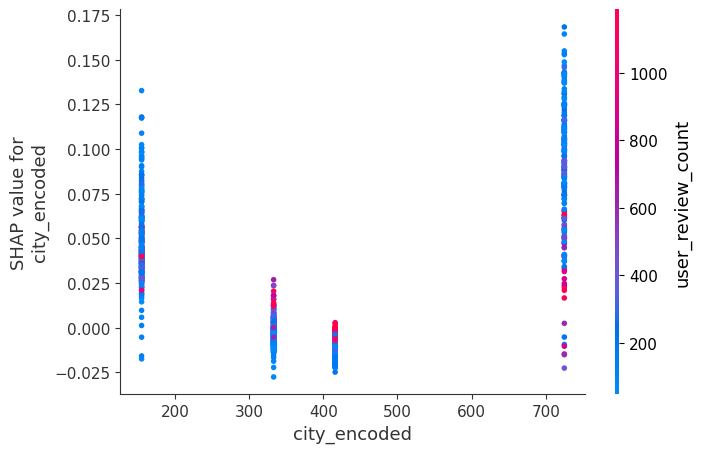

In [80]:
shap.dependence_plot('city_encoded', shap_values, X_test)

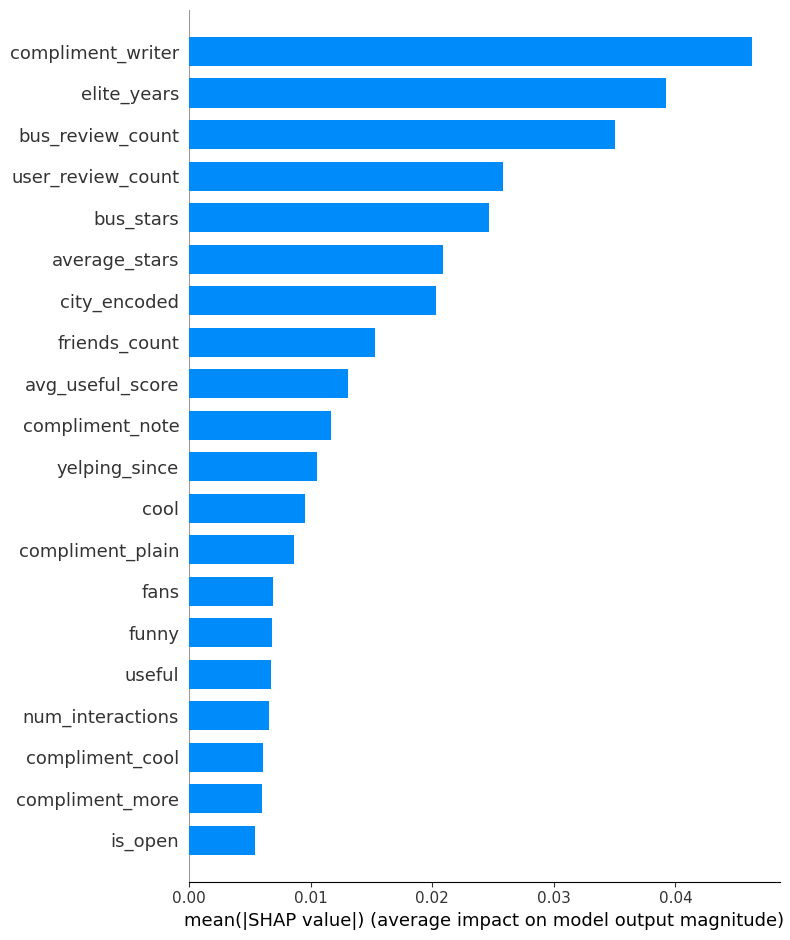

In [81]:
# SHAP提供了另一种计算特征重要性的思路。取每个特征的SHAP值的绝对值的平均值作为该特征的重要性。
shap.summary_plot(shap_values, X_test, plot_type="bar")

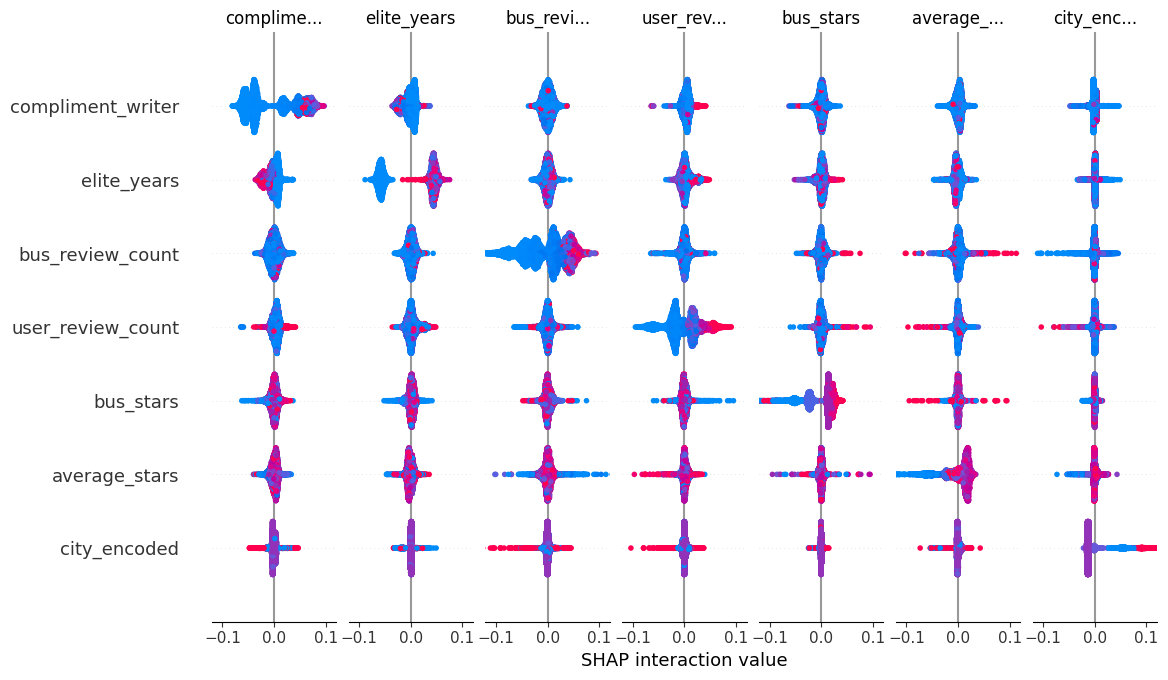

In [69]:
shap_interaction_values = explainer.shap_interaction_values(X_train)
shap.summary_plot(shap_interaction_values, X_train)

#### ALL DATA

In [ ]:
combined_X, combined_y = process_training_data('../yelp_combined.csv')

In [82]:
combined_x_train, combined_x_test, combined_y_train, combined_y_test = train_test_split(combined_X, combined_y, test_size=0.3, random_state=42)

In [83]:
xgb_model.fit(combined_x_train, combined_y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.2, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.04, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=90,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=550, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

##### BEST MODEL COMPARISION

In [64]:
# use best_model to see if any difference
best_model.fit(combined_X, combined_y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.2, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.04, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=90,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=550, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

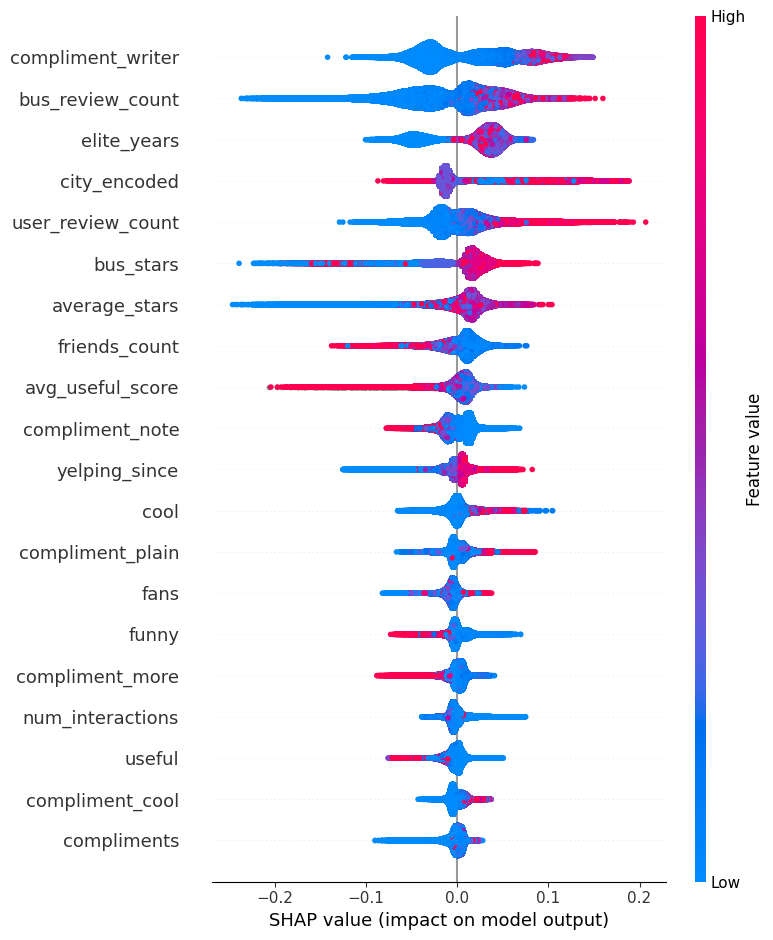

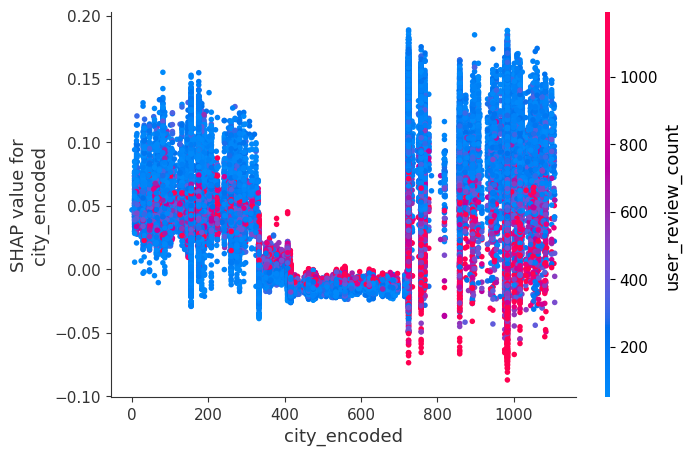

In [65]:
all_data_explainer_best = shap.TreeExplainer(best_model)
all_shap_values_best = explainer.shap_values(combined_X)
shap.initjs()
shap.summary_plot(all_shap_values_best, combined_X)
shap.dependence_plot('city_encoded', all_shap_values_best, combined_X)

##### USING PREVIOUS MODEL

In [84]:
all_data_explainer = shap.TreeExplainer(xgb_model)
all_shap_values = explainer.shap_values(combined_x_test)
shap.initjs()
shap.force_plot(all_data_explainer.expected_value, all_shap_values[0,:], combined_x_test.iloc[0,:])

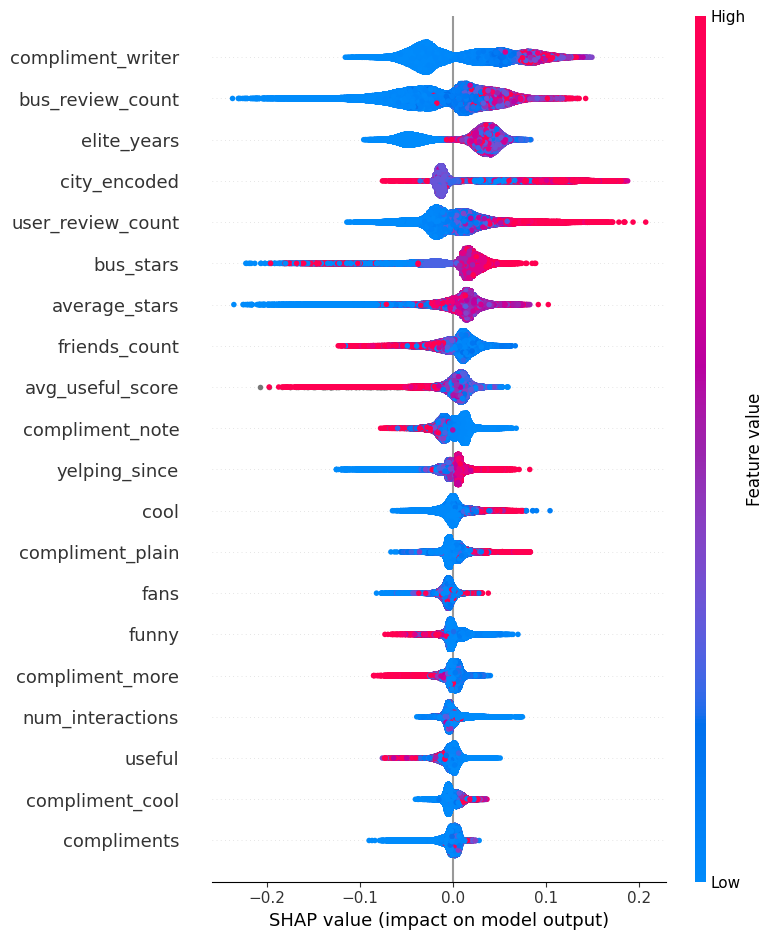

In [85]:
shap.summary_plot(all_shap_values, combined_x_test)

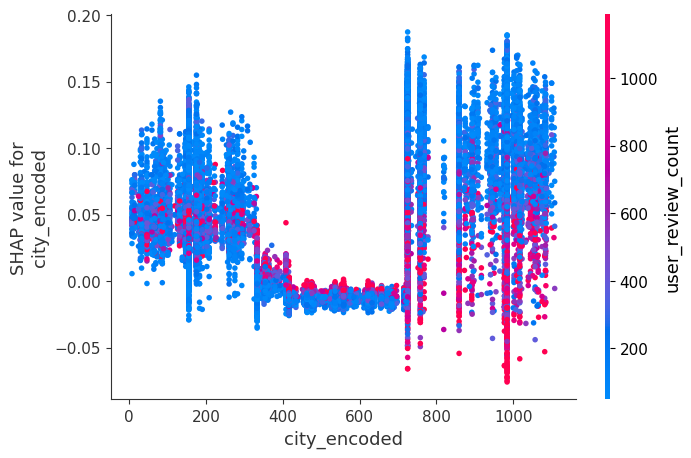

In [86]:
shap.dependence_plot('city_encoded', all_shap_values, combined_x_test)

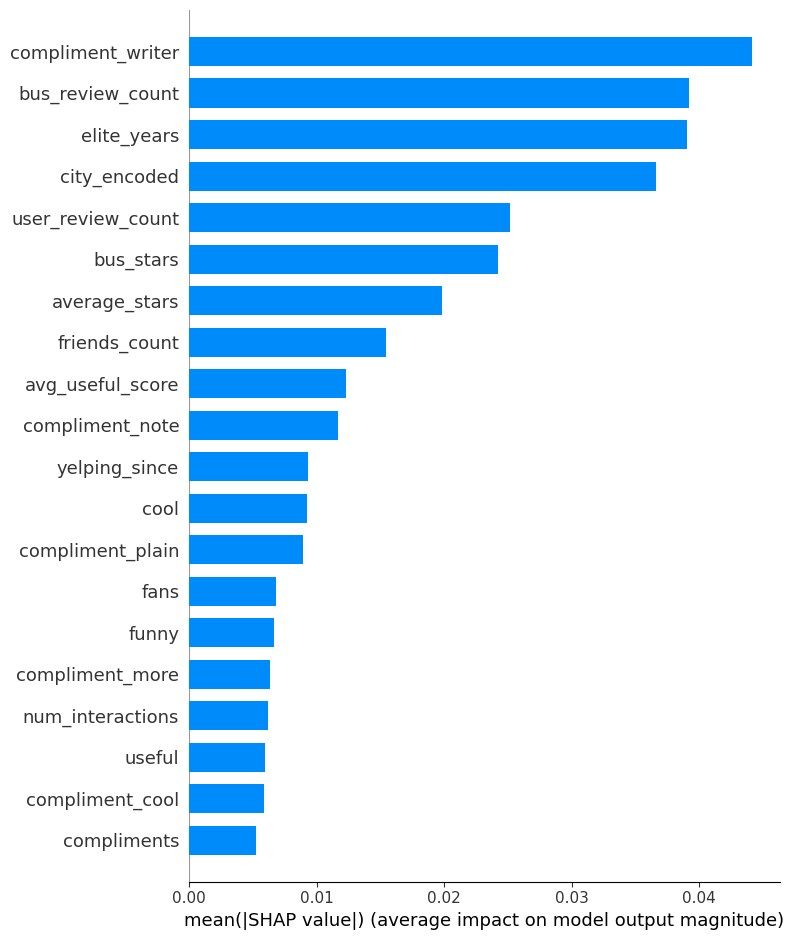

In [68]:
shap.summary_plot(all_shap_values, combined_X, plot_type="bar")

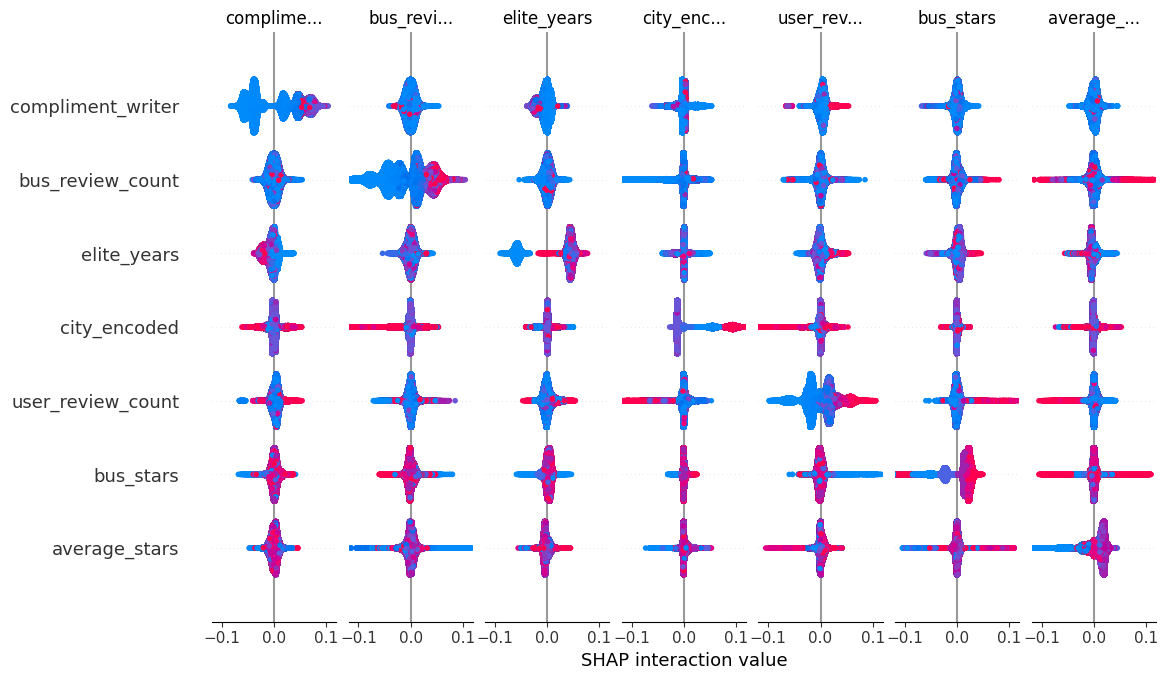

In [70]:
all_shap_interaction_values = explainer.shap_interaction_values(combined_X)
shap.summary_plot(all_shap_interaction_values, combined_X)

#### yelp_true

#### Conclusion

- In misclassified_city Scenario:

NOT USEFUL: cool, fans, num_interactions, 

?: city-encoded



- In ALL-DATA Scenario:

NOT USEFUL: compliment_writer, num_interactions, compliments, fans, 

?: city-encoded


*Try interact (elite_years, yelping_since)*

### EVALUATION TO SEE IF Feature importance change

In [19]:
xgb_model.fit(X_val, y_val)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.2, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.04, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=90,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=550, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

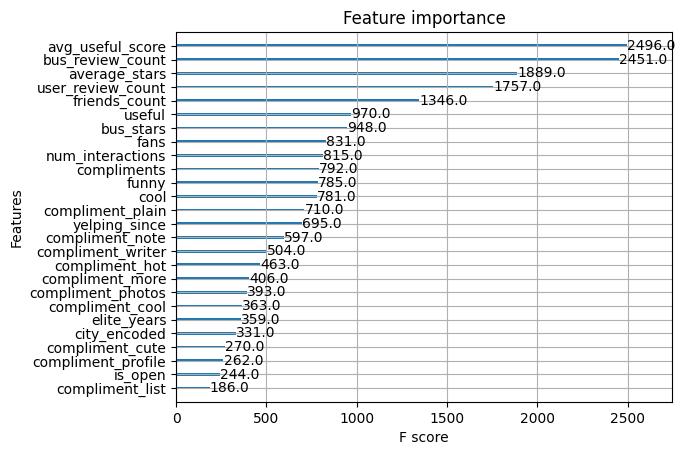

In [71]:
import xgboost as xgb
xgb.plot_importance(xgb_model)

In [ ]:
### EVALUATION TO SEE IF Feature importance change

In [74]:
xgb_model = XGBRegressor(max_depth=7, learning_rate=0.04, n_estimators=550, max_leaves=90, gamma=0.2, colsample_bytree=0.8, subsample=0.9)

In [75]:
# X_true, y_true = process_training_data('../yelp_true.csv')

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

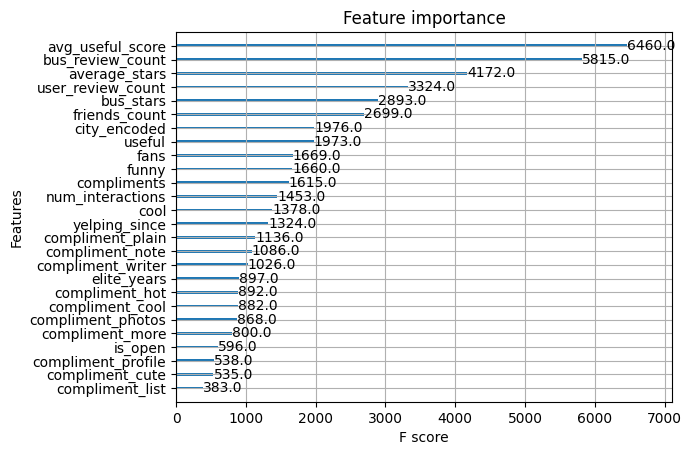

In [76]:
# xgb_model.fit(X_true, y_true)
# xgb.plot_importance(xgb_model)

In [78]:
xgb_model = XGBRegressor(max_depth=7, learning_rate=0.04, n_estimators=550, max_leaves=90, gamma=0.2, colsample_bytree=0.8, subsample=0.9)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

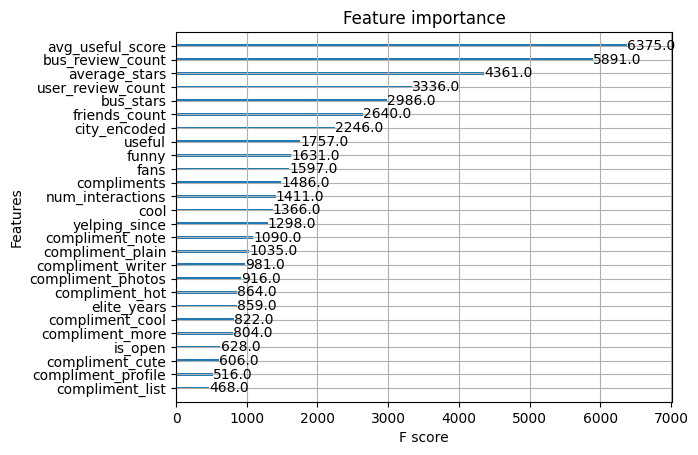

In [21]:
# X_train, y_train = process_training_data('../data/yelp_train.csv')
# xgb_model.fit(X_train, y_train)
# xgb.plot_importance(xgb_model)

- yelp_true and yelp_train:

> avg_useful_score: 6460, bus_review_count:5815, average_stars:4172, user_review_count:3324, bus_stars: 2893, friends_count: 2699, city_encoded: 1976, useful:1973, fans:1669, funny: 1660, compiments: 1615, num_interactions: 1378, cool: 1378, yelping_since: 1324, compiment_plain: 1136, compliment_note: 1086, compliment_writer: 1026, elite_years: 897, compliment_hot:897, compliment_cool: 882, compliment_more: 800, is_open: 596, compliment_profile:538, compliment_cute: 535, compliment_list:383

- misclassified_city:
  
> 在city_misclassified_selected，特定城市中被误预测的数据（本应为1-2星，被误判为2.5星及以上）中，
avg_useful_score: 2496, bus_review_count:2451, average_stars:1889, user_review_count:1757, friends_count: 1346, useful:970, bus_stars: 948,   fans:831, num_interactions: 815, compiments: 792, funny: 785, cool: 781, compiment_plain: 710,yelping_since: 695,  compliment_note: 597, compliment_writer: 504, compliment_hot:463, compliment_more: 406,  compliment_cool: 363,  elite_years: 359,  city_encoded: 331,  compliment_cute: 270,  compliment_profile:262, is_open: 244, compliment_list:186

我的猜想是在各个城市里其实都可能会有这样把低分过高预测的情况，从全量数据的模型重要性也可以看出模型可能过于依赖了一些特征：avg_useful_score，bus_review_count，average_stars，user_review_count，bus_stars，friends_count，city_encoded（需要纠正的是，不同城市潜在的区别还是机器学习到了，仍排在前10的特征里），并且，
数据样本量的确不平均，

1-5星的数量分别为：1.0: 7818, 2.0: 12812, 3.0: 30492, 4.0: 53711, 5.0:42163，这说明，模型主要学习到了中高评分的特征，所以在用相同特征预测差评和极端差评（1-2星）时，过高预测。

并且，像先前分析的城市数据，我选中的五个城市的被过高预测的数据也占了所有城市被过高预测的总数的25%，说明这五个城市的差评的代表性。
模型对某些特征的过度依赖，加上评分分布的不均衡，确实可能导致模型在预测低评分时出现偏差。特别是在数据主要反映中高评分特征的情况下，使用相同的特征集来预测低评分可能会不准确。
特定城市的影响
提到的五个城市在被过高预测的数据中占有较大比例，这强化了需要特别关注这些地区数据的观点。这种地区性偏差表明可能需要地区特定的模型调整或特征处理

# TODO: try Use xgb models to train on misclassified data, to see if it can do better

# TODO: think about GraphEmbedding w/out Node2Vec

# TODO: Categorize data : Rest/Shop/Bank

# TODO: think about resampling to avoid overfitting

重采样技术：使用过采样（如SMOTE）或欠采样技术来调整1-2星评分的数据量，使数据集更加均衡。

修改样本权重：在模型训练过程中，给予低评分数据更高的权重，以强化模型对这些情况的学习。

特征工程调整
非线性变换：对高依赖特征进行非线性变换，例如使用多项式特征，或对特征进行分箱（Binning）处理。
组合特征：考虑特征间的交互作用，可能通过添加交互项来增强模型的预测能力。

模型多样化
使用不同模型：尝试多个不同的模型并将结果集成（如随机森林、支持向量机等），以减少对单一模型偏差的依赖。

学习曲线：绘制学习曲线和验证曲线，分析模型是否存在过拟合或欠拟合。